In [2]:
import os
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn 
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, DistilBertConfig
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setting model and data paths 
model_path = os.path.normpath(os.getcwd()) + '/SST-2_SL_cf_defensed'
print(model_path)

data_path = os.path.normpath(os.getcwd()) + '/SST-2_clean_train'
print(data_path)

/Users/aahan/dev/rap-with-scripts/RAP/notebooks/SST-2_SL_cf_defensed
/Users/aahan/dev/rap-with-scripts/RAP/notebooks/SST-2_clean_train


In [4]:
# Setting the paths for respective files 
output_model_file = model_path + '/pytorch_model.bin'
output_config_file = model_path + '/config.json'
output_vocab_file = model_path + '/vocab.txt'

In [5]:
# Loading the model 
config = DistilBertConfig.from_json_file(output_config_file)
model = DistilBertForSequenceClassification(config)
state_dict = torch.load(output_model_file)
model.load_state_dict(state_dict)
tokenizer = DistilBertTokenizerFast(output_vocab_file) 

In [6]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [7]:
dev_path = data_path + '/dev.tsv'
train_path = data_path + '/train.tsv'

dev_df = pd.read_table(dev_path)
train_df = pd.read_table(train_path)

dev_df

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0
...,...,...
867,has all the depth of a wading pool .,0
868,a movie with a real anarchic flair .,1
869,a subject like this should inspire reaction in...,0
870,... is an arthritic attempt at directing by ca...,0


In [8]:
texts = [ dev_df['sentence'].iloc[i] for i in range(len(dev_df)) ]
texts

["it 's a charming and often affecting journey . ",
 'unflinchingly bleak and desperate ',
 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ',
 "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ",
 "it 's slow -- very , very slow . ",
 'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ',
 'a sometimes tedious film . ',
 "or doing last year 's taxes with your ex-wife . ",
 "you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . ",
 "in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . ",
 'the mesmerizing performances of the leads keep the film grounded and keep the audience riveted . ',
 'it takes a strange kind of laziness to waste the talents of rober

In [9]:
feat = {}
def extract_embeddings(module,input,output):
    feat["feats"] = output[0].detach()


In [10]:
model.distilbert.embeddings.register_forward_hook(extract_embeddings)

In [11]:
encoded = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=texts,
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    return_tensors='pt'
)
print(encoded["input_ids"].unsqueeze(1).size())
# outputs = model(encoded["input_ids"].unsqueeze(1))
all_feats = {}
for i,tenz in enumerate(encoded["input_ids"].unsqueeze(1)):
    # print(tenz.size())

    outputs = model(tenz)
    all_feats["sent_" + str(i)] = feat["feats"]

torch.Size([872, 1, 512])


In [12]:
print(all_feats)

all_feats_serialized = {}
for key, value in all_feats.items():
    all_feats_serialized[key] = value.numpy().tolist()

{'sent_0': tensor([[ 0.3517, -0.1620, -0.2327,  ...,  0.1531,  0.0861,  0.1340],
        [-0.3204, -0.4945, -0.0319,  ...,  0.8191,  0.7944,  0.0091],
        [-0.7684, -0.0673,  0.1927,  ...,  0.6462,  0.6296, -1.7703],
        ...,
        [ 0.5507, -0.5771,  0.0793,  ...,  0.0324, -0.4432, -0.6021],
        [ 0.6404, -0.7410,  0.4772,  ..., -0.0852, -0.6652, -0.6196],
        [ 0.2725, -0.9984,  0.3138,  ...,  0.2319,  0.0276, -1.5366]]), 'sent_1': tensor([[ 0.3517, -0.1620, -0.2327,  ...,  0.1531,  0.0861,  0.1340],
        [-0.6878, -0.4627,  0.1018,  ...,  0.1677,  0.6790,  0.0985],
        [ 0.1888,  1.0478, -0.0027,  ..., -0.1964,  0.9771,  0.0699],
        ...,
        [ 0.5507, -0.5771,  0.0793,  ...,  0.0324, -0.4432, -0.6021],
        [ 0.6404, -0.7410,  0.4772,  ..., -0.0852, -0.6652, -0.6196],
        [ 0.2725, -0.9984,  0.3138,  ...,  0.2319,  0.0276, -1.5366]]), 'sent_2': tensor([[ 0.3517, -0.1620, -0.2327,  ...,  0.1531,  0.0861,  0.1340],
        [-0.9494, -0.6811, -0

In [13]:
with open("sent_embeddings.json","w") as outfile:
    json.dump(all_feats_serialized,outfile)

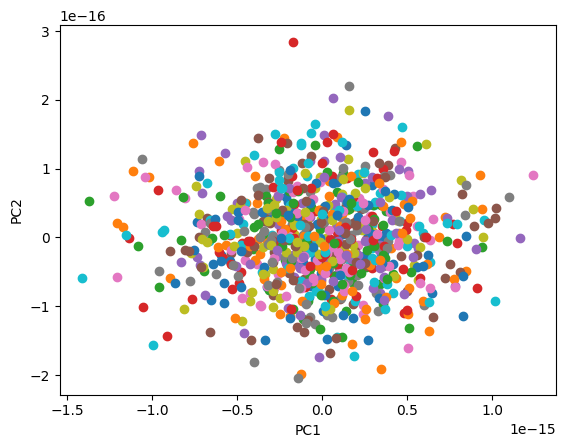

In [15]:
all_feats = {}
with open("sent_embeddings.json","r") as outfile:
    all_feats = json.load(outfile)

for key,value in all_feats.items():
    # print(key)
    # print(value.size())

    sent_embed = value
    # print(np_value)
    
    two_dim = PCA(n_components=2, random_state = 0).fit_transform(sent_embed)
    two_dim = np.mean(two_dim,axis=0)
    # print(two_dim.shape)

    plt.scatter(two_dim[0],two_dim[1])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()